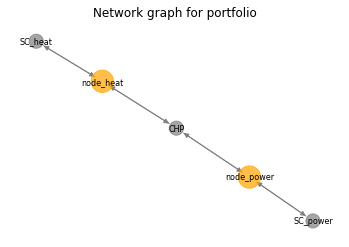

In [1]:
import eaopack as eao
import numpy as np
import datetime as dt
from eaopack.portfolio import Portfolio
from eaopack.basic_classes import Timegrid
from eaopack.optimization import Results

node_power = eao.assets.Node('node_power')
node_heat = eao.assets.Node('node_heat')

timegrid = eao.assets.Timegrid(dt.date(2021, 1, 1), dt.date(2021, 1, 2), freq='h', main_time_unit='h')
simple_contract1 = eao.assets.SimpleContract(name='SC_power', price='price_power', nodes=node_power,
                                            min_cap=-30., max_cap=20)
simple_contract2 = eao.assets.SimpleContract(name='SC_heat', price='price_heat', nodes=node_heat,
                                            min_cap=-30., max_cap=20.)

chpcontract = eao.assets.CHPContract(name='CHP', 
                                     nodes=[node_power, node_heat],
                                     min_cap=10., 
                                     max_cap=30.,
                                     extra_costs=0,
                                     freq='h',
                                     alpha=0.5, 
                                     beta=0.5,
                                     ramp=20, 
                                     start_costs=0.1, 
                                     running_costs=0., 
                                     min_runtime=2., 
                                     time_already_running=0., 
                                     last_dispatch=0.)

prices = {'price_power': np.sin(0.5*np.pi * np.arange(timegrid.T)*np.pi/10),
          'price_heat': np.cos(0.5*np.pi * np.arange(timegrid.T)*np.pi/10), 
          }

portfolio = eao.portfolio.Portfolio([chpcontract, simple_contract1, simple_contract2])
eao.network_graphs.create_graph(portf = portfolio)

In [2]:
op = portfolio.setup_optim_problem(prices, timegrid)
res = op.optimize(solver="GLPK_MI")
print("Value:", res.value)

...MIP problem configured. Beware of potentially long optimization and other issues inherent to MIP
Value: 276.05429948644803


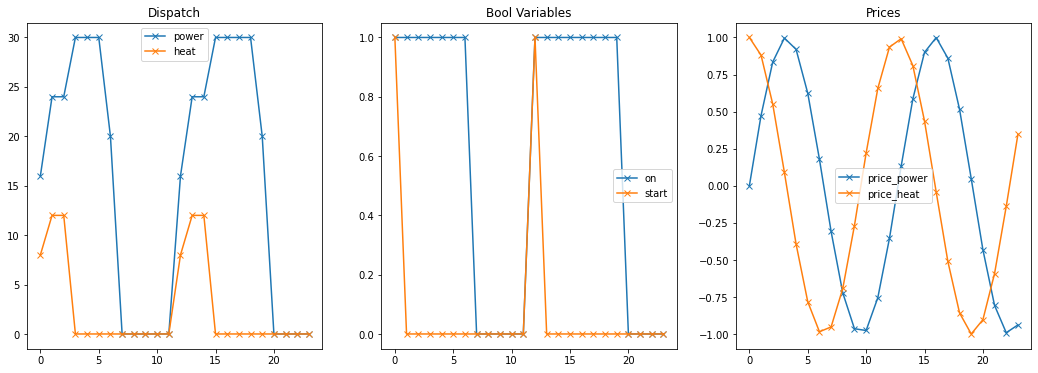

In [3]:
import matplotlib.pyplot as plt

n = timegrid.T
plt.figure(figsize=(18, 6))
plt.subplot(1,3,1)
plt.title("Dispatch")
plt.plot(res.x[:n], 'x-', label="power")
plt.plot(res.x[n:2*n], 'x-', label="heat")
plt.legend()

plt.subplot(1,3,2)
plt.title("Bool Variables")
n_vars_chp = len(op.mapping.index[op.mapping['asset']==chpcontract.name])
if n_vars_chp >= 3*n:
    plt.plot(res.x[2*n: 3*n], 'x-', label="on")
if n_vars_chp >= 4*n:
    plt.plot(res.x[3*n:4*n], 'x-', label="start")
plt.legend()


plt.subplot(1,3,3)
plt.title("Prices")
for key in prices:
    plt.plot(prices[key], 'x-', label = key)
plt.legend()